In [1]:
!git clone https://github.com/Bhavya171/LLM_From_Scratch

fatal: destination path 'LLM_From_Scratch' already exists and is not an empty directory.


In [2]:
%cd /content/LLM_From_Scratch

/content/LLM_From_Scratch


In [3]:
!pip install tiktoken

# Chapter 5

In [4]:
from previous_chapters import GPTModel

In [5]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## text to tokens and vice versa

We will write 2 functions
1. to convert text to tokens
2. to convert tokens to text

The flow is something like

text -> text to tokens -> model -> tokens to text -> output

In [6]:
# text to tokens

import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("output: ", token_ids_to_text(token_ids, tokenizer))

output:  Every effort moves you rentingetic wasnم refres RexMeCHicular stren


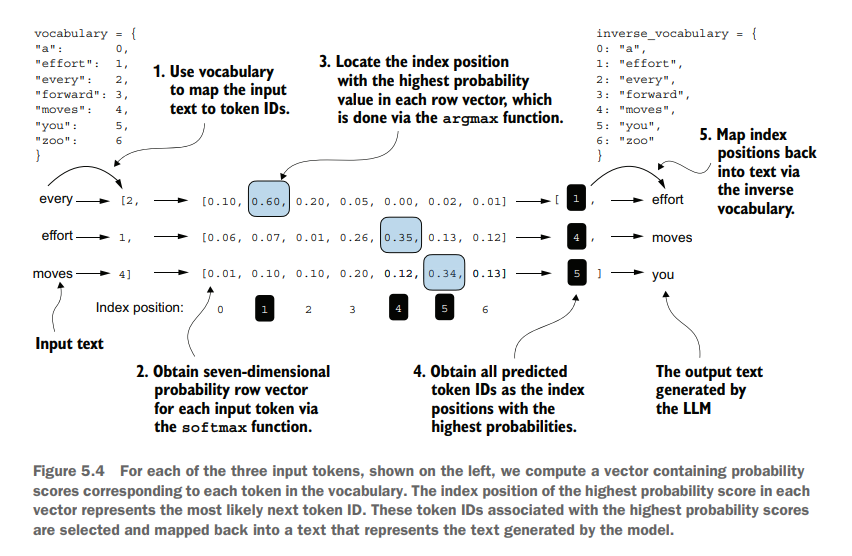

This is a sample text from out vocabulary

In [7]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
 [40, 1107, 588]]) # "I really like"]

Targets are nothing but 1 shift from the inputs as discussed in chapter 2

In [8]:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]


Now we feed this input to the model and then we apply softmax to get the probability distribution which will tell us the importance of each word in the sentence.

In [9]:
with torch.no_grad(): # disables gradient because we are not training yet STEP 1 from fig
  logits = model(inputs)
probas = torch.softmax(logits,dim = -1) # probability of each token in vocabulary STEP 2 from fig
print(probas.shape)

torch.Size([2, 3, 50257])


In [10]:
token_ids = torch.argmax(probas,dim = -1, keepdim = True) # step 3 and 4
print("token IDs: ", token_ids)

token IDs:  tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [11]:
# step 5 converting back to text

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Before training, the model produces random probability vector.
the purpose of training is to maximize the values that correspond to the index of the token in the target vector

In [12]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1: ", target_probas_1)

text_idx = 0
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2: ", target_probas_2)

Text 1:  tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2:  tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])


## Calculating loss

The target of trainingis to maximize the likelihood of the correct token which involves increasing the probability relative to other tokens.

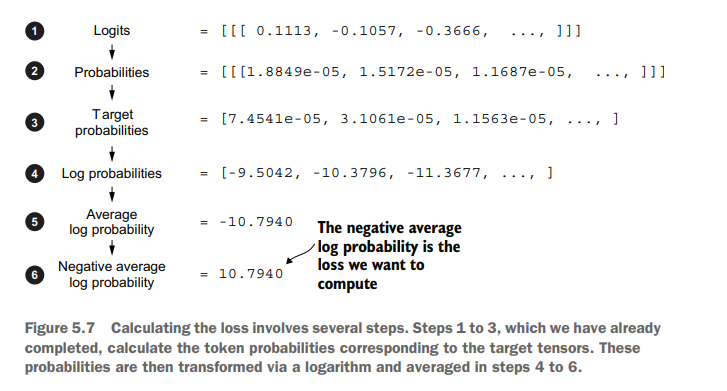

In [13]:
# step 1-3 are done this is step 4

log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677,  -9.5042, -10.3796, -11.3677])


In [14]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.4172)


Note that this is the loss which should be as close to 0 as possible which is done by training the model. Major aim is to reduce this loss function to 0.

In deep learning normal habit is to bring negative of log function to 0 rather than bringing this to 0.


In [15]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.4172)


In deep learing the term forturning this negative value into positive is called **CROSS ENTROPY** loss.

In [16]:
print(logits.shape) # [batch_size,number_of_tokens, vocabulary_size]
print(targets.shape)# [batch_size,number_of_tokens]

torch.Size([2, 3, 50257])
torch.Size([2, 3])


In [17]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("flattened logits: ", logits_flat.shape)
print("flattened targets: ", targets_flat.shape)

flattened logits:  torch.Size([6, 50257])
flattened targets:  torch.Size([6])


**Remember the targets are the token ids we want our model to generate. And the logits contain the unscaled model outputs before the softmax function is applied to obtain the probability scores**


In [18]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss) # same as calculated before

tensor(10.7940)


## Calculating loss for training and validation dataset

Taking the verdict file as dataset

In [19]:
file_path = "/content/LLM_From_Scratch/the-verdict.txt"
with open(file_path, "r" , encoding = "utf-8") as file:
  text_data = file.read()

checking the number of characters and tokens in the dataset


In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(total_characters)
print(total_tokens)

20479
5145


training data = 90%

validation data = 10%

In [21]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]



In [22]:
from previous_chapters import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [23]:
print("Train loader: ")
for x,y in train_loader:
  print(x.shape,y.shape)

print("Val loader: ")
for x,y in val_loader:
  print(x.shape,y.shape)



Train loader: 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Val loader: 
torch.Size([2, 256]) torch.Size([2, 256])


Function for calculating the cross entropy

In [24]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten()
  )
  return loss

In [25]:
# function to compute training and val loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch,target_batch,model,device
      )
      total_loss += loss.item()
    else:
      break

  return total_loss / num_batches

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
 train_loss = calc_loss_loader(train_loader, model, device)
 val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


## Training the model

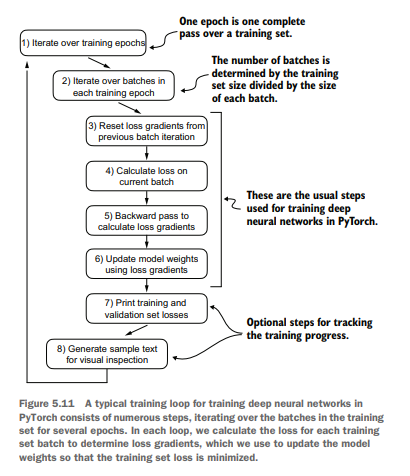

In [27]:
# main function for pretraining LLMs

def train_model_simple(model, train_loader, val_loader, optimizer, device,
                      num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1            #  initalising lists to store the losses
  for epoch in range(num_epochs):  # starting of the iteration process
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()     #  resets the loss gradient from previous epochs

      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )

      loss.backward()  # calculatesthe loss gradient
      optimizer.step()  # upodates the model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:  # optional evaluation step
        train_loss, eval_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(eval_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, "
              f"Val loss {eval_loss:.3f}"
              )
    generate_and_print_sample(model, tokenizer, device, start_context)  # prints sample text aafter each epoch

  return train_losses, val_losses, track_tokens_seen


Note that we have 2 functions which are still undefined


In [28]:
# defining evaluate_model

# this corresponds to step 7 in the figure where we print the lossees to avaluate the performance of training the model

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval() # Dropout is disable during the evaluation process for stable reslts
  with torch.no_grad():
    train_loss = calc_loss_loader( # disables gradient tracking because we dont need it in evaluation
        train_loader, model, device, num_batches = eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
    )

  model.train()
  return train_loss, val_loss

In [29]:
# generate_and_print_sample function takes a text snippet and converts it into token ids and feed it to model to generate a text

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(
        model = model,
        idx = encoded,
        max_new_tokens = 50, context_size = context_size
    )

  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

evaluate_model gives us a numeric estimate where as generate_and_print_sample provides a concrete text example generated by the model to judge its capabilities during training

In [30]:
# trainng the GPTModel for 10 epochs

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr = 0.0004, weight_decay = 0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs = num_epochs, eval_freq = 5, eval_iter = 5,
    start_context = "Every effort moves you", tokenizer = tokenizer
)


Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

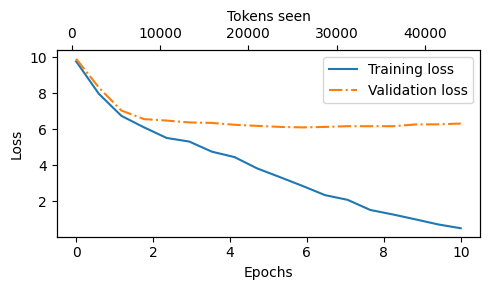

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
 fig, ax1 = plt.subplots(figsize=(5, 3))
 ax1.plot(epochs_seen, train_losses, label="Training loss")
 ax1.plot(
 epochs_seen, val_losses, linestyle="-.", label="Validation loss"
 )
 ax1.set_xlabel("Epochs")
 ax1.set_ylabel("Loss")
 ax1.legend(loc="upper right")
 ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
 ax2 = ax1.twiny()
 ax2.plot(tokens_seen, train_losses, alpha=0)
 ax2.set_xlabel("Tokens seen")
 fig.tight_layout()
 plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Strategies to control randomness

In [32]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [33]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M['context_length']
)
print("Output text: ", token_ids_to_text(token_ids,tokenizer))

Output text:  Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




## temperature scaling

In [34]:
vocab = {
    "closer": 0,
    "every": 1,
    "efffort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [35]:
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [36]:
# mapping generate_Text_simple back

probas = torch.softmax(next_token_logits, dim = 0)
next_token_ids = torch.argmax(probas).item()
print(inverse_vocab[next_token_ids])

forward


In [37]:
# we can replace argmax with multinomial function

torch.manual_seed(123)
next_token_id = torch.multinomial(probas,num_samples = 1).item()
print(inverse_vocab[next_token_id]) # not every time forward is called as seen in the next cell

toward


In [38]:
def print_sampled_tokens(probas):
 torch.manual_seed(123)
 sample = [torch.multinomial(probas, num_samples=1).item()
            for i in range(1_000)]
 sampled_ids = torch.bincount(torch.tensor(sample))
 for i, freq in enumerate(sampled_ids):
  print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x efffort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Temperature scalling is just a fancy description for dividing the logits by a number greater then 0

In [39]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim = 0)

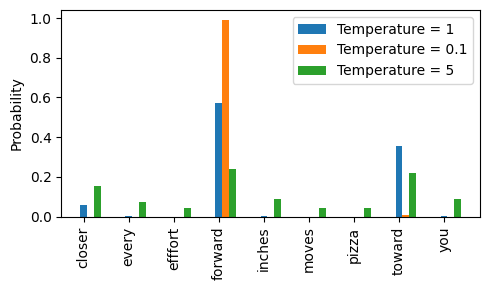

In [40]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
 rects = ax.bar(x + i * bar_width, scaled_probas[i],
 bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

greater temperature values results in more uniformdistribution where as small temperature values results in more precision

## Top k scaling


In this we chosse the top k logits values and mask all other by -inf before applying the softmax because after softmax they will turn to 0. with this we can say that the output will definitely be from the top k logits only and no other logit.

In [41]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("top logits: ", top_logits)
print("top pos: ", top_pos)

top logits:  tensor([6.7500, 6.2800, 4.5100])
top pos:  tensor([3, 7, 0])


In [42]:
# masking the non top k values with -inf

new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [43]:
topk_probas = torch.softmax(new_logits, dim = 0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


we can now apply the temperature scaling and multinomial function for probabilistic sampling to select the next token among these 3 non zero probability scores

## modifying the text generation function

In [44]:
# we now combine temperature scaling and top k sampling to modify the function

def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None:
      top_logits,_ = torch.topk(logits,top_k)
      min_value = top_logits[:, -1]
      logits = torch.where(
          logits < min_value,
          torch.tensor(float('-inf')).to(logits.device),
          logits
      )
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples = 1)
    else:
      idx_next = torch.argmax(logits, dim = -1, keepdim = True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx,idx_next), dim = -1)
  return idx

In [45]:
torch.manual_seed(123)
token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M['context_length'],
    top_k = 25,
    temperature = 1.4
)
print("output: ", token_ids_to_text(token_ids, tokenizer))

output:  Every effort moves you know began to my surprise, a little it was the
"Ah enough


## loading and saving model weights

In [46]:
torch.save(model.state_dict(), "model.pth")

In [47]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [55]:
torch.save({
    "epochs": num_epochs,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
  },
    "model_and_optimizer.pth"
)

In [56]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();